In [3]:
import sys
sys.path.append("..")

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from datasets.backdoor_dataset import CIFAR10M,CustomDataset_224,CIFAR10Mem
import numpy as np
from datasets.bd_dataset_imagenet_filter import BadEncoderDataset

torch.cuda.set_device(0)

def dataloader(dataset):
    batch_size=2048
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        transforms.RandomGrayscale(p=0.8),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

In [4]:
import torch.nn.functional as F
import os,random,copy
import kornia.augmentation as A

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假定已经定义了model, wanet, train_loader和test_loader

class ProbTransform(torch.nn.Module):
    def __init__(self, f, p=1):
        super(ProbTransform, self).__init__()
        self.f = f
        self.p = p

    def forward(self, x):  # , **kwargs):
        if random.random() < self.p:
            return self.f(x)
        else:
            return x


class PostTensorTransform(torch.nn.Module):
    def __init__(self):
        super(PostTensorTransform, self).__init__()
        self.random_crop = ProbTransform(
            A.RandomCrop((32, 32), padding=5), p=0.8
        )
        self.random_rotation = ProbTransform(A.RandomRotation(10), p=0.5)


    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


def wanet(clean_img):
    input_height=32
    grid_rescale=1
    s=0.5
    k=4
    num_bd = clean_img.shape[0] // 2
    num_cross = num_bd
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=input_height, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .cuda()
    )
    array1d = torch.linspace(-1, 1, steps=input_height)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].cuda()

    grid_temps = (identity_grid + s * noise_grid / input_height) * grid_rescale
    grid_temps = torch.clamp(grid_temps, -1, 1)
    transforms = PostTensorTransform().cuda()

    ins = torch.rand(num_cross, input_height, input_height, 2).cuda() * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / input_height
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(clean_img[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)

    inputs_cross = F.grid_sample(clean_img[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    total_inputs = torch.cat([inputs_bd, inputs_cross], dim=0)
    backdoored_img = transforms(total_inputs)
    return backdoored_img



# def train_and_test_model(model, train_loader, test_loader):
#     # 训练模式
#     # 定义损失函数和优化器
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epochs=30

#     model.train()
#     for epoch in range(epochs):  # 多个周期
#         train_loss = 0.0
#         for clean_img, aug_img in tqdm(train_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             # 使用wanet处理clean_img
#             wanet_bd = wanet(clean_img)

#             # 准备输入数据和标签
#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             # 清零梯度
#             optimizer.zero_grad()

#             # 前向传播，反向传播，优化
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)

#         print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

#     # 测试模式
#     model.eval()
#     correct = 0
#     total = 0
#     test_loss = 0.0
#     y_true = []
#     y_pred = []
#     y_score = []

#     with torch.no_grad():
#         for clean_img, aug_img in tqdm(test_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             wanet_bd = wanet(clean_img)

#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(outputs, 1)
#             probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())

#     avg_loss = test_loss / total
#     accuracy = 100 * correct / total
#     f1 = f1_score(y_true, y_pred)
#     auroc = roc_auc_score(y_true, y_score)

#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')



def train_and_test_model_tsne(model, train_loader, test_loader):
    # 省略训练部分的代码...
    model.fc = nn.Identity()  # 移除最后一层
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs=15

    model.train()
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()

            # 前向传播，反向传播，优化
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

    # 测试模式
    model.eval()
    features_list = []
    labels_list = []
    model.fc = nn.Identity()  # 二分类

    with torch.no_grad():
        for clean_img, aug_img in tqdm(test_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = model(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels,
        palette=sns.color_palette("hsv", 2),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE visualization of model features')
    plt.show()
# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作

In [5]:
# # 加载预训练的ResNet50模型并修改最后一层以适应二分类任务
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 二分类
model = model.cuda()  # 确保模型在CUDA设备上

# 定义损失函数（虽然在测试中可能不需要，除非你想计算损失）
# criterion = nn.CrossEntropyLoss()

/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/3 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 1, Train Loss: 15.6157


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 2, Train Loss: 13.4815


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 3, Train Loss: 12.8558


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 4, Train Loss: 12.6447


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 5, Train Loss: 12.3469


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 6, Train Loss: 12.2365


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 7, Train Loss: 12.2394


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 8, Train Loss: 12.2575


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 9, Train Loss: 12.1200


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 10, Train Loss: 11.9746


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 11, Train Loss: 11.8487


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 12, Train Loss: 11.7770


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 13, Train Loss: 11.7490


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 14, Train Loss: 11.7383


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 15, Train Loss: 11.6115


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


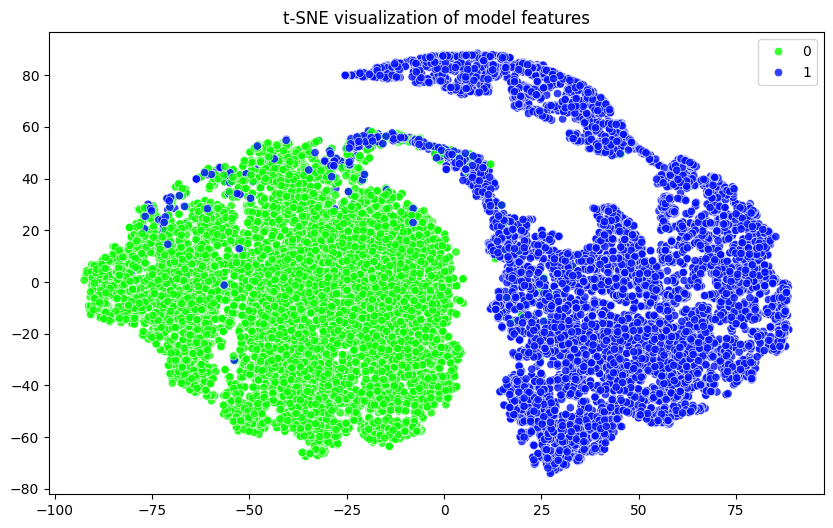

In [6]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/36 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 36/36 [00:35<00:00,  1.02it/s]


Epoch 1, Train Loss: 12.5869


100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


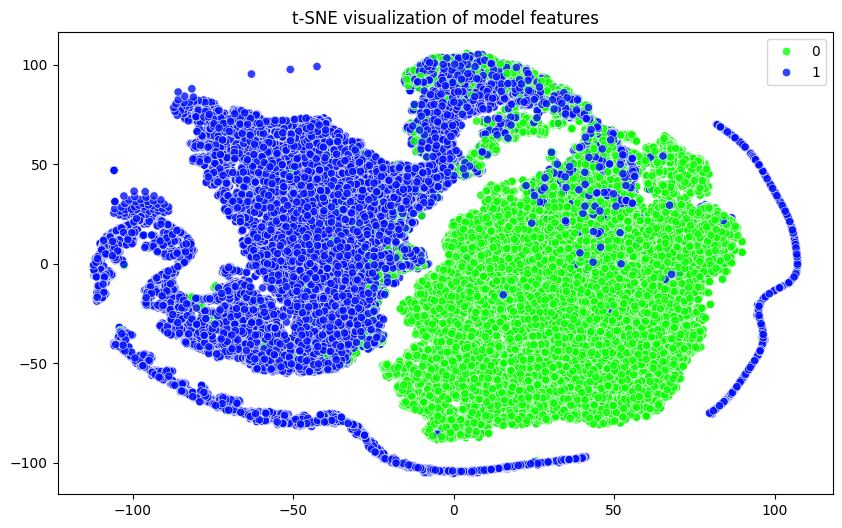

In [5]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/3 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 1, Train Loss: 12.5296


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


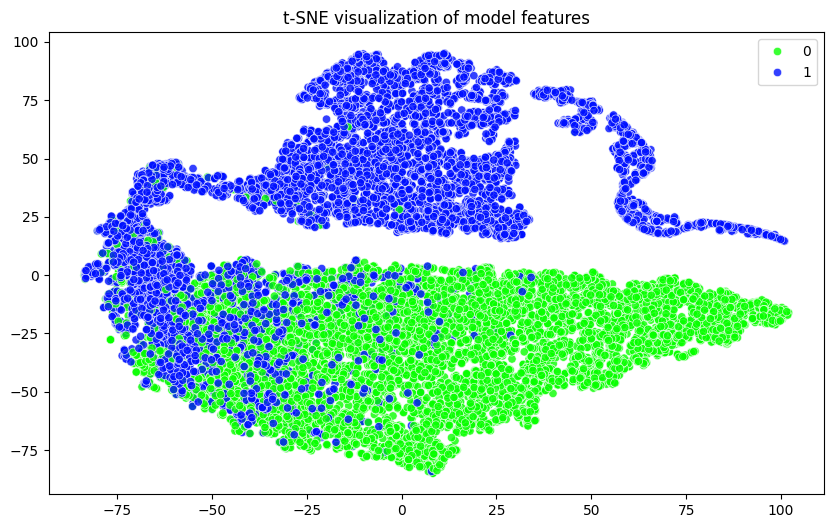

In [6]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 1, Train Loss: 11.6748


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


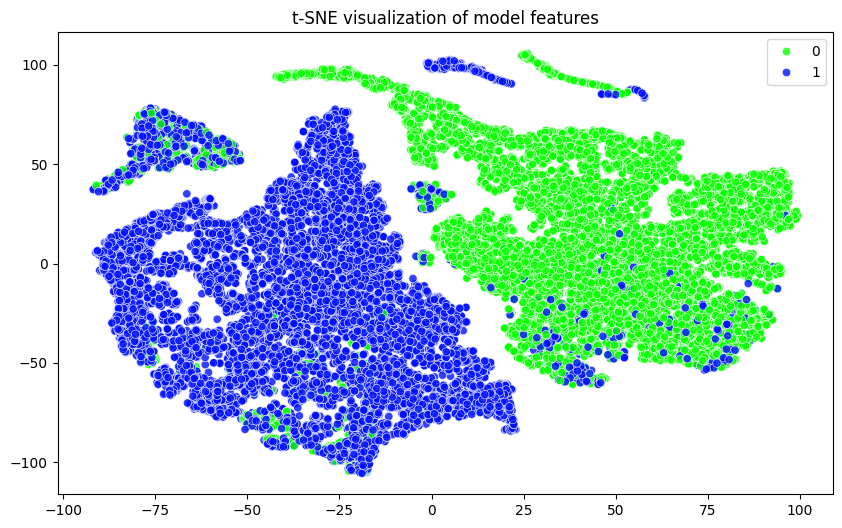

In [7]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


Epoch 1, Train Loss: 12.7663


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


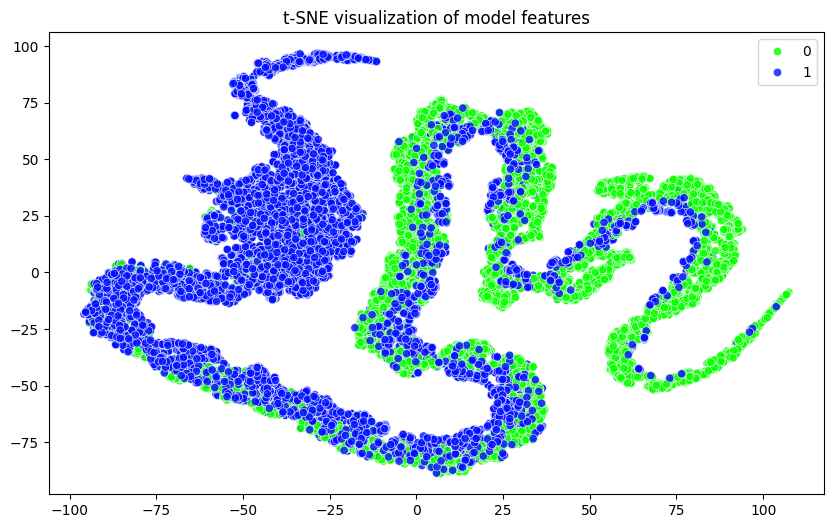

In [6]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/36 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 36/36 [00:36<00:00,  1.00s/it]


Epoch 1, Train Loss: 11.7726


100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


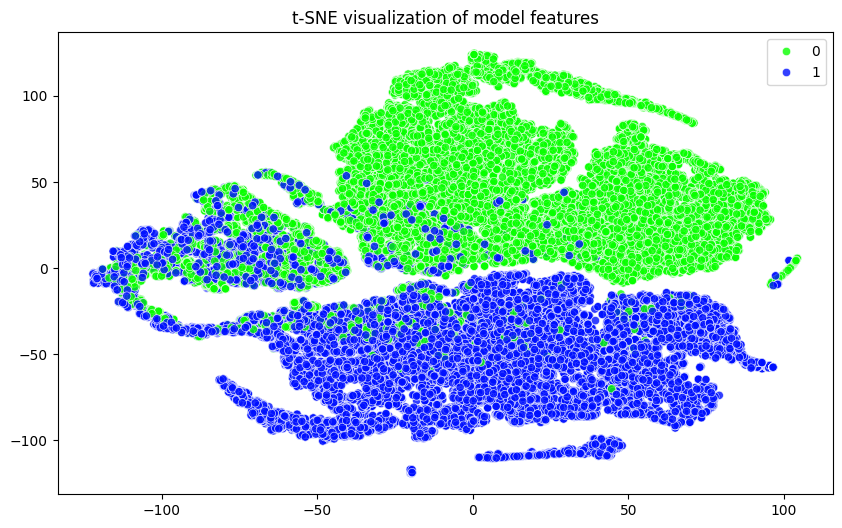

In [10]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/8 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 1, Train Loss: 12.2045


100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


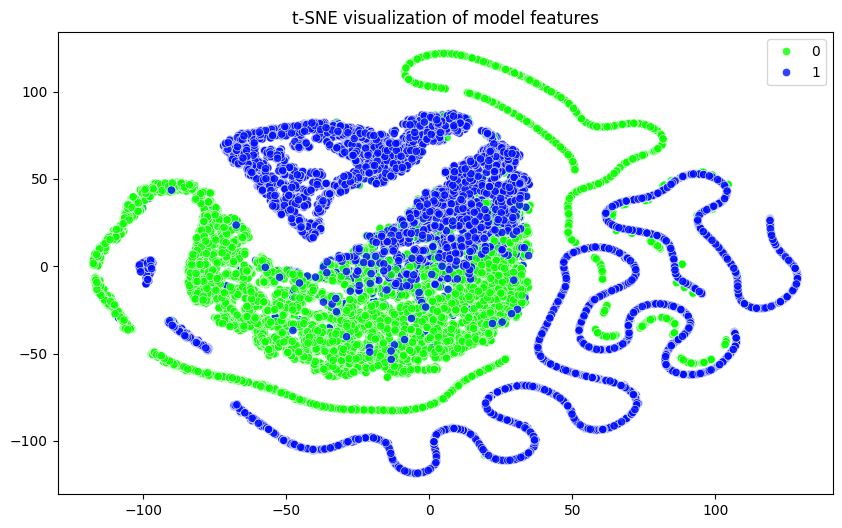

: 

In [8]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model_tsne(model, train_loader, test_loader)

100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Epoch 1, Train Loss: 12.9101


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


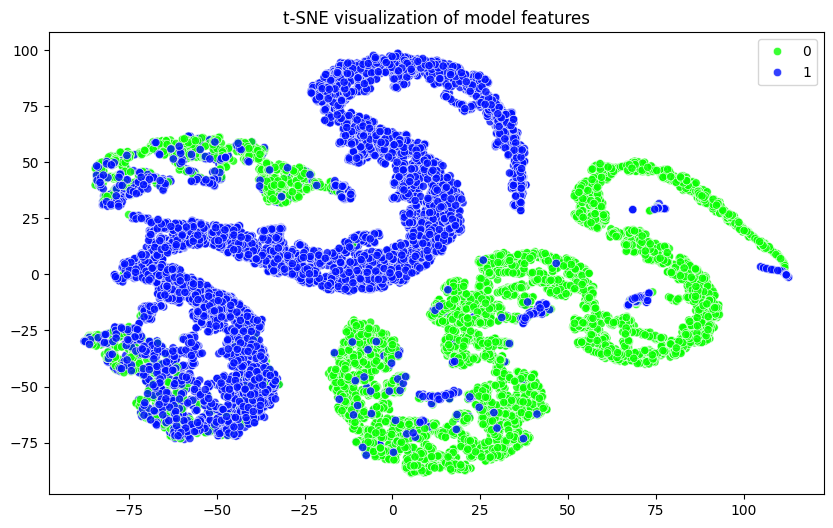

In [23]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/15 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


Epoch 1, Train Loss: 12.3268


100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


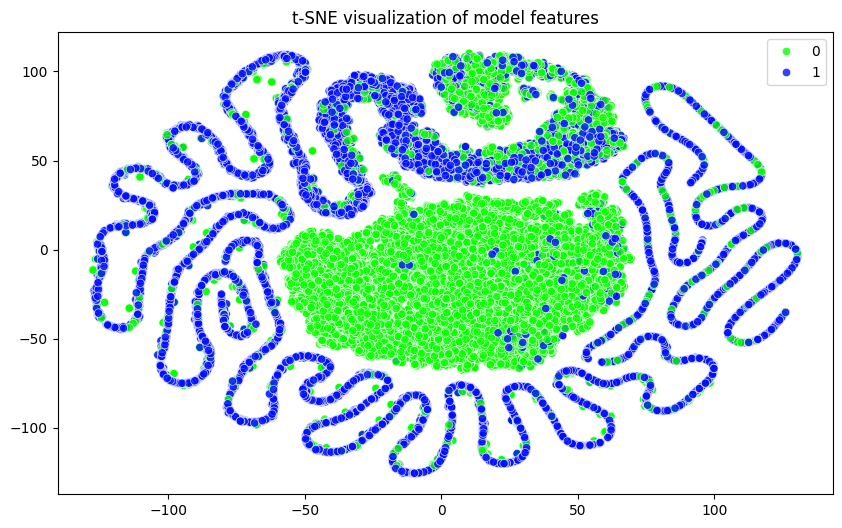

In [24]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model_tsne(model, train_loader, test_loader)

  0%|          | 0/8 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 1, Train Loss: 12.1375


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


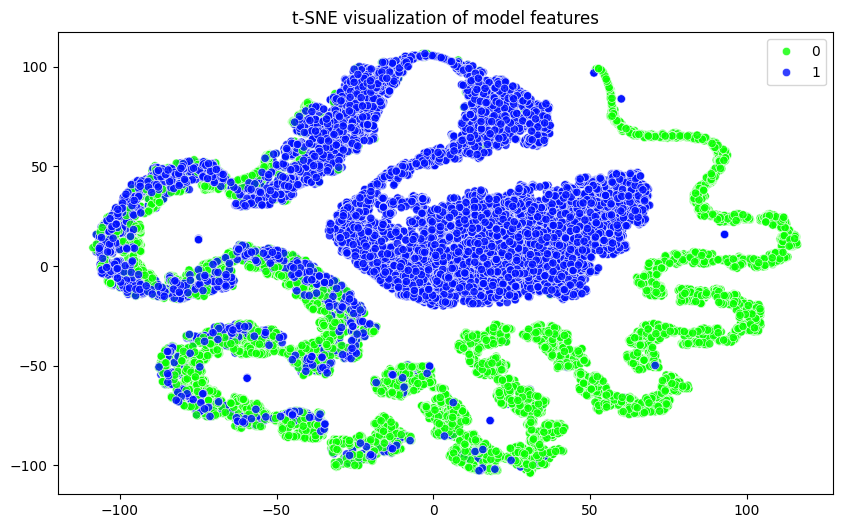

In [25]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model_tsne(model, train_loader, test_loader)

In [11]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Epoch 1, Train Loss: 1.5562


100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch 2, Train Loss: 6.6296


100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Epoch 3, Train Loss: 1.6676


100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


Epoch 4, Train Loss: 1.3253


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Epoch 5, Train Loss: 1.2597


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Epoch 6, Train Loss: 1.2310


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


Epoch 7, Train Loss: 0.9630


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


Epoch 8, Train Loss: 0.9351


100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


Epoch 9, Train Loss: 0.7284


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


Epoch 10, Train Loss: 0.6252


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch 11, Train Loss: 0.5497


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Epoch 12, Train Loss: 0.8518


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


Epoch 13, Train Loss: 0.3502


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch 14, Train Loss: 0.3217


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


Epoch 15, Train Loss: 0.4351


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


Epoch 16, Train Loss: 0.4024


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Epoch 17, Train Loss: 0.3801


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


Epoch 18, Train Loss: 0.6394


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


Epoch 19, Train Loss: 0.2871


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Epoch 20, Train Loss: 0.5233


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


Epoch 21, Train Loss: 0.5829


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


Epoch 22, Train Loss: 0.2488


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


Epoch 23, Train Loss: 0.3204


100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


Epoch 24, Train Loss: 0.2822


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


Epoch 25, Train Loss: 0.2175


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Epoch 26, Train Loss: 0.5007


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


Epoch 27, Train Loss: 0.2444


100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


Epoch 28, Train Loss: 0.2414


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Epoch 29, Train Loss: 0.1625


100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Epoch 30, Train Loss: 0.5096


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

Test Loss: 0.0910, Accuracy: 96.48%, F1 Score: 0.9644, AUROC: 0.9954


In [12]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/15 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 1, Train Loss: 0.4302


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 2, Train Loss: 0.2261


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


Epoch 3, Train Loss: 0.1368


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 4, Train Loss: 0.1442


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


Epoch 5, Train Loss: 0.1587


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 6, Train Loss: 0.1137


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 7, Train Loss: 0.1057


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 8, Train Loss: 0.1714


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 9, Train Loss: 0.0872


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 10, Train Loss: 0.0676


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 11, Train Loss: 0.0604


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 12, Train Loss: 0.0807


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 13, Train Loss: 0.1608


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 14, Train Loss: 0.0790


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 15, Train Loss: 0.0976


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 16, Train Loss: 0.1317


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 17, Train Loss: 0.0810


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 18, Train Loss: 0.0905


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch 19, Train Loss: 0.0788


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 20, Train Loss: 0.1239


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 21, Train Loss: 0.0587


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 22, Train Loss: 0.0971


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 23, Train Loss: 0.0687


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 24, Train Loss: 0.0950


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 25, Train Loss: 0.0536


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 26, Train Loss: 0.0779


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 27, Train Loss: 0.0622


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 28, Train Loss: 0.0442


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 29, Train Loss: 0.0485


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 30, Train Loss: 0.0584


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]

Test Loss: 0.1737, Accuracy: 94.06%, F1 Score: 0.9439, AUROC: 0.9951


In [13]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/8 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 1, Train Loss: 0.3242


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 2, Train Loss: 0.2396


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


Epoch 3, Train Loss: 0.1226


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 4, Train Loss: 0.1177


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 5, Train Loss: 0.1102


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


Epoch 6, Train Loss: 0.0951


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 7, Train Loss: 0.0474


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 8, Train Loss: 0.0196


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 9, Train Loss: 0.0590


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 10, Train Loss: 0.0634


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 11, Train Loss: 0.0538


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 12, Train Loss: 0.0409


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 13, Train Loss: 0.0425


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 14, Train Loss: 0.0538


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 15, Train Loss: 0.0550


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 16, Train Loss: 0.0571


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 17, Train Loss: 0.0269


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 18, Train Loss: 0.0287


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 19, Train Loss: 0.0361


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 20, Train Loss: 0.0333


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 21, Train Loss: 0.0289


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 22, Train Loss: 0.0279


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 23, Train Loss: 0.0451


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


Epoch 24, Train Loss: 0.0514


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 25, Train Loss: 0.0613


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 26, Train Loss: 0.0432


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 27, Train Loss: 0.0356


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


Epoch 28, Train Loss: 0.0337


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 29, Train Loss: 0.0140


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 30, Train Loss: 0.0517


100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

Test Loss: 0.0127, Accuracy: 99.53%, F1 Score: 0.9953, AUROC: 0.9999
